In [1]:
import pandas as pd

import pvlib
import cpvsystem as cpvlib

module_params = {
    "gamma_ref": 5.524,
    "mu_gamma": 0.003,
    "I_L_ref": 0.96,
    "I_o_ref": 0.00000000017,
    "R_sh_ref": 5226,
    "R_sh_0": 21000,
    "R_sh_exp": 5.50,
    "R_s": 0.01,
    "alpha_sc": 0.00,
    "EgRef": 3.91,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 12,
    "cells_in_parallel": 48,
    "eta_m": 0.32,
    "alpha_absorption": 0.9,
    "Area": 1.2688,
    "Impo": 8.3,
    "Vmpo": 43.9,
}

UF_parameters = {
    "IscDNI_top": 0.96 / 1000,
    "aoi_thld": 61.978505569631494,
    "aoi_uf_m_low": -2.716773886925838e-07,
    "aoi_uf_m_high": -1.781998474992582e-05,
    "am_thld": 4.574231933073185,
    "am_uf_m_low": 3.906372068620377e-06,
    "am_uf_m_high": -3.0335768119184845e-05,
    "ta_thld": 50,
    "ta_uf_m_low": 4.6781224141650075e-06,
    "ta_uf_m_high": 0,
    "weight_am": 0.2,
    "weight_temp": 0.8,
}

module_params.update(UF_parameters)

In [2]:
meteo = pd.read_csv('meteo2020_03_04.txt', sep='\t', index_col='yyyy/mm/dd hh:mm', parse_dates=True)
meteo.index = meteo.index.tz_localize('Europe/Madrid')

location = pvlib.location.Location(latitude=40.4, longitude=-3.7, altitude=695, tz='Europe/Madrid')

In [3]:
static_cpv_sys = cpvlib.StaticCPVSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module=None,
    module_parameters=module_params,
    modules_per_string=1,
    strings_per_inverter=1,
    inverter=None,
    inverter_parameters=None,
    racking_model="insulated",
    losses_parameters=None,
    name=None,
)

meteo['dii'] = pvlib.irradiance.beam_component(
    static_cpv_sys.surface_tilt,
    static_cpv_sys.surface_azimuth,
    solar_zenith=location.get_solarposition(meteo.index).zenith,
    solar_azimuth=location.get_solarposition(meteo.index).azimuth,
    dni=meteo['Bn']
    )

celltemp = static_cpv_sys.pvsyst_celltemp(
    meteo['dii'], meteo['Temp. Ai 1'], meteo['V.Vien.1']
)

diode_parameters = static_cpv_sys.calcparams_pvsyst(
    meteo['dii'], celltemp)
   
dc = static_cpv_sys.singlediode(*diode_parameters)

C:\Users\Ruben\OneDrive - Universidad Politécnica de Madrid\1-IES\3-Modelo CPV Insolight\cpvlib\cpvsystem.py:210: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


In [4]:
uf_am = static_cpv_sys.get_am_util_factor(airmass=location.get_airmass(meteo.index).airmass_absolute)

uf_ta = static_cpv_sys.get_tempair_util_factor(temp_air=meteo['Temp. Ai 1'])

uf_am_at = uf_am * module_params['weight_am'] + uf_ta * module_params['weight_temp']

uf_aoi = static_cpv_sys.get_aoi_util_factor(
    aoi=static_cpv_sys.get_aoi(
            solar_zenith=location.get_solarposition(meteo.index).zenith,
            solar_azimuth=location.get_solarposition(meteo.index).azimuth,
            )
)

uf_aoi_ast = static_cpv_sys.get_aoi_util_factor(aoi=0)

uf_aoi_norm = uf_aoi / uf_aoi_ast

uf_global = uf_am_at * uf_aoi_norm

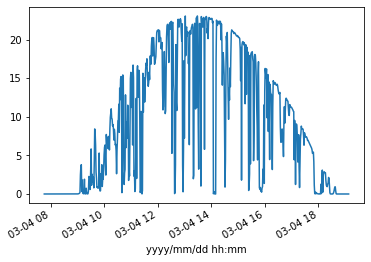

In [5]:
(dc['p_mp'] * uf_global).plot()